# CTA 2D source fitting with Sherpa


## Prepare sky images
We first create counts, exposure, background and PSF maps, following the steps under "Make sky images" in the cta_data_analysis Notebook:

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.units as u
from gammapy.image import SkyImage, IACTBasicImageEstimator
from gammapy.background import RingBackgroundEstimator
from gammapy.data import DataStore

from regions import CircleSkyRegion
import numpy as np

# Create reference image: 6x6 deg FOV centered on (l,b) = (300,0)
target_position = SkyCoord(300, 0, unit='deg', frame='galactic')

xref = target_position.galactic.l.value
yref = target_position.galactic.b.value

ref_image = SkyImage.empty(
    nxpix=300, nypix=300, binsz=0.02,
    xref=xref, yref=yref,
    proj='TAN', coordsys='GAL')

We initially define no exclusion regions for the background estimation, as we have not yet determined the positions of sources in the field of view:

Name: None
Data shape: (300, 300)
Data type: bool
Data unit: 
Data mean: 9.780e-01
WCS type: ['GLON-TAN', 'GLAT-TAN']



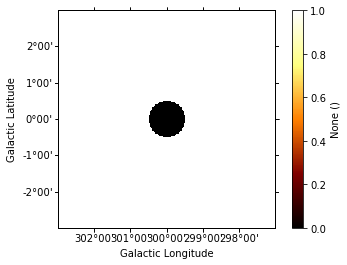

In [50]:
on_region = CircleSkyRegion(center=SkyCoord(300, 0, unit='deg',
                            frame='galactic'), radius=0.5 * u.deg)
excl_mask = ref_image.region_mask(on_region)
excl_mask.data = np.invert(excl_mask.data)

# excl_mask = ref_image
# excl_mask.data = ref_image.data == 0

print(excl_mask)
excl_mask.plot(add_cbar=True)

bkg_estimator = RingBackgroundEstimator(
    r_in=0.5 * u.deg,
    width=0.2 * u.deg)

Set the map energy threshold at 300 GeV, which seems a good compromise for source detection sensitivity: with a low threshold the background is more important, but too high a threshold yields limited source statistics.

In [51]:
image_estimator = IACTBasicImageEstimator(
    reference=ref_image,
    emin=0.3 * u.TeV,
    emax=100 * u.TeV,
    offset_max=4 * u.deg,
    background_estimator=bkg_estimator,
    exclusion_mask=excl_mask)

OBS_ID
------
110040
110122
110120
110081
110078
110121
110079
110080
110038
110039 observations within radius 4 deg


/Users/facero/Documents/Work/Program/gammapy/gammapy/gammapy/cube/core.py:85: RuntimeWarning: divide by zero encountered in log
  log_data = np.log(self.data.value)


counts


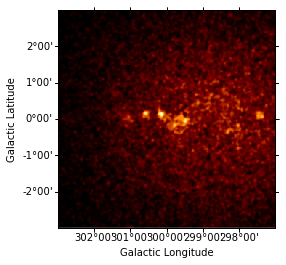

exposure


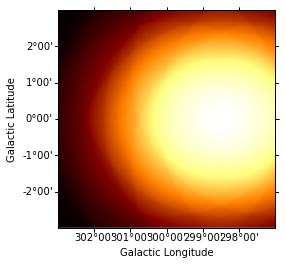

background


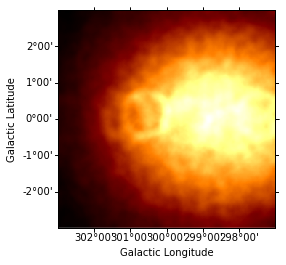

excess


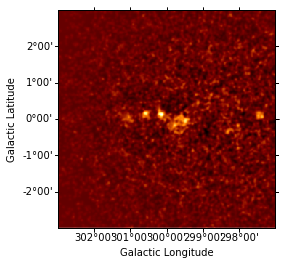

flux


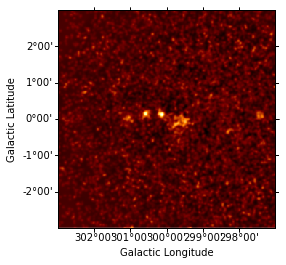

psf


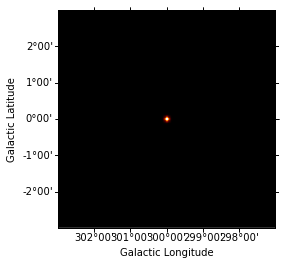

In [52]:
# Should work if the environment variable CTADATA is set;
# otherwise, change the path to your index file directory.
INDX_DIR = '../handson/index/gps'

data_store = DataStore.from_dir(INDX_DIR)

ras = data_store.obs_table['RA_PNT'] * u.deg
decs = data_store.obs_table['DEC_PNT'] * u.deg
pointings = SkyCoord(ras, decs, frame='icrs' )
dists = pointings.separation(target_position)
obs_id = data_store.obs_table['OBS_ID'][(dists < 4 * u.deg)]
print((obs_id), "observations within radius 4 deg")

obslist = data_store.obs_list(obs_id)
images = image_estimator.run(obslist)

for i,im in enumerate(images):
    print(images.names[i])
    im.smooth(radius=3).plot() ; plt.show()

Now save the obtained images as FITS files for import into Sherpa:

In [53]:
images['counts']    .write("G300-0_test_counts.fits", clobber=True)
images['exposure']  .write("G300-0_test_exposure.fits", clobber=True)
images['background'].write("G300-0_test_background.fits", clobber=True)

# Hack to convert PSF data from an array of Quantity's to a float array:
images['psf'].data = images['psf'].data.value
images['psf']       .write("G300-0_test_psf.fits", clobber=True)


## Fit sources with Sherpa
Set up Sherpa to fit the counts map, loading the ancillary images for subsequent use. A relevant test statistic for data with Poisson fluctuations is the one proposed by Cash (1979). The simplex (or Nelder-Mead) fitting algorithm is a good compromise between efficiency and robustness. The source fit is best performed in pixel coordinates.

In [54]:
import sherpa.astro.ui as sh
from gammapy.image import SkyImage
from regions.core.pixcoord import PixCoord
from regions.shapes.circle import CirclePixelRegion

sh.set_stat("cash")
sh.set_method("simplex")
sh.load_image("G300-0_test_counts.fits")
sh.set_coord("logical")

#sh.load_image('bkg',images['background'].data)


sh.load_table_model("expo", "G300-0_test_exposure.fits")
sh.load_table_model("bkg",  "G300-0_test_background.fits")
sh.load_psf        ("psf",  "G300-0_test_psf.fits")

In principle one might first want to fit the background amplitude. However the background estimation method already yields the correct normalization, so we freeze the background amplitude to unity instead of adjusting it. The (smoothed) residuals from this background model are then computed and shown.

(<matplotlib.figure.Figure at 0x120495ac8>,
 None)

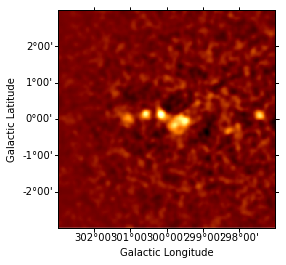

In [60]:
sh.set_full_model(bkg)
bkg.ampl = 1
sh.freeze(bkg)

sh.save_resid("resid.fits", clobber=True)
resid = SkyImage.read("resid.fits")
resid.wcs = ref_image.wcs
resid_smo6 = resid.smooth(radius = 6)
resid_smo6.plot()

### Find and fit the brightest source
We then find the position of the maximum in the (smoothed) residuals map, and fit a (symmetrical) Gaussian source with that initial position:

In [56]:
maxcoord = resid_smo6.lookup_max()
maxpix = resid_smo6.wcs_skycoord_to_pixel(maxcoord[0])
sh.set_full_model(bkg + psf(sh.gauss2d.g0) * expo) # creates g0 as a gauss2d instance
g0.xpos = maxpix[0]
g0.ypos = maxpix[1]
sh.freeze(g0.xpos, g0.ypos) # fix the position in the initial fitting step

expo.ampl = 1e-9 # fix exposure amplitude so that typical exposure is of order unity
sh.freeze(expo)
sh.thaw(g0.fwhm, g0.ampl) # in case frozen in a previous iteration

g0.fwhm = 10 # give some reasonable initial values
g0.ampl = maxcoord[1]
sh.fit() # Performs the fit; this takes a little time.

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 97176.1
Final fit statistic   = 96771.1 at function evaluation 236
Data points           = 90000
Degrees of freedom    = 89998
Change in statistic   = 404.999
   g0.fwhm        6.40444     
   g0.ampl        0.402707    


Fit all parameters of this Gaussian component, fix them and re-compute the residuals map.

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96771.1
Final fit statistic   = 96766.6 at function evaluation 321
Data points           = 90000
Degrees of freedom    = 89996
Change in statistic   = 4.5674
   g0.fwhm        6.30668     
   g0.xpos        141.917     
   g0.ypos        156.309     
   g0.ampl        0.420184    


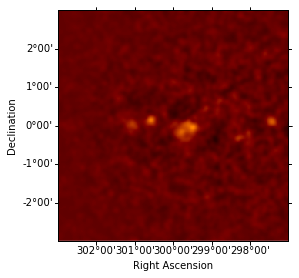

In [57]:
sh.thaw(g0.xpos, g0.ypos)
sh.fit()
sh.freeze(g0)

sh.save_resid("resid.fits", clobber=True)
resid = SkyImage.read("resid.fits")
resid_smo6 = resid.smooth(radius = 6)
resid_smo6.show(vmin = -0.5, vmax = 2)

### Iteratively find and fit additional sources
Instantiate additional Gaussian components, and use them to iteratively fit sources, repeating the steps performed above for component g0. (The residuals map is shown after each additional source included in the model.) This takes some time...

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96766.6
Final fit statistic   = 96602.2 at function evaluation 273
Data points           = 90000
Degrees of freedom    = 89998
Change in statistic   = 164.306
   g1.fwhm        20.0626     
   g1.ampl        0.0997644   
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96602.2
Final fit statistic   = 96561.5 at function evaluation 336
Data points           = 90000
Degrees of freedom    = 89996
Change in statistic   = 40.7466
   g1.fwhm        19.9715     
   g1.xpos        167.28      
   g1.ypos        144.3       
   g1.ampl        0.11579     


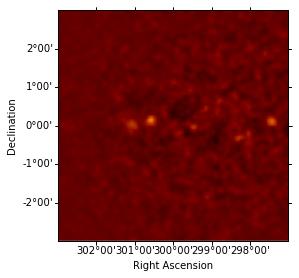

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96561.5
Final fit statistic   = 96472.1 at function evaluation 252
Data points           = 90000
Degrees of freedom    = 89998
Change in statistic   = 89.38
   g2.fwhm        5.83932     
   g2.ampl        0.402999    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96472.1
Final fit statistic   = 96469.7 at function evaluation 301
Data points           = 90000
Degrees of freedom    = 89996
Change in statistic   = 2.44074
   g2.fwhm        5.73001     
   g2.xpos        120.793     
   g2.ypos        156.765     
   g2.ampl        0.420805    


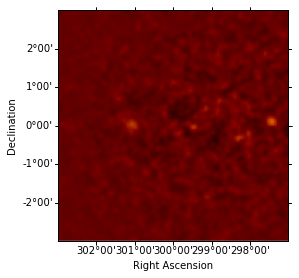

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96469.7
Final fit statistic   = 96414.5 at function evaluation 254
Data points           = 90000
Degrees of freedom    = 89998
Change in statistic   = 55.221
   g3.fwhm        6.54721     
   g3.ampl        0.222759    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96414.5
Final fit statistic   = 96410 at function evaluation 288
Data points           = 90000
Degrees of freedom    = 89996
Change in statistic   = 4.44935
   g3.fwhm        6.52534     
   g3.xpos        277.705     
   g3.ypos        155.145     
   g3.ampl        0.234563    


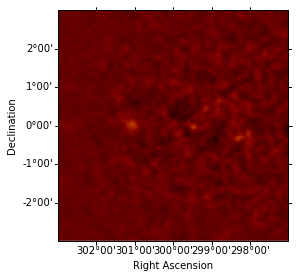

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96410
Final fit statistic   = 96352.5 at function evaluation 292
Data points           = 90000
Degrees of freedom    = 89998
Change in statistic   = 57.5231
   g4.fwhm        11.6177     
   g4.ampl        0.141858    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96352.5
Final fit statistic   = 96352.1 at function evaluation 331
Data points           = 90000
Degrees of freedom    = 89996
Change in statistic   = 0.420866
   g4.fwhm        11.8083     
   g4.xpos        95.4034     
   g4.ypos        150.656     
   g4.ampl        0.140502    


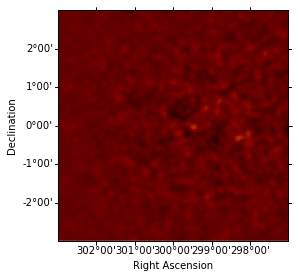

Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96352.1
Final fit statistic   = 96327.4 at function evaluation 265
Data points           = 90000
Degrees of freedom    = 89998
Change in statistic   = 24.6592
   g5.fwhm        3.40525     
   g5.ampl        0.344846    
Dataset               = 1
Method                = neldermead
Statistic             = cash
Initial fit statistic = 96327.4
Final fit statistic   = 96327.3 at function evaluation 286
Data points           = 90000
Degrees of freedom    = 89996
Change in statistic   = 0.0816143
   g5.fwhm        3.68942     
   g5.xpos        234.115     
   g5.ypos        133.254     
   g5.ampl        0.303322    


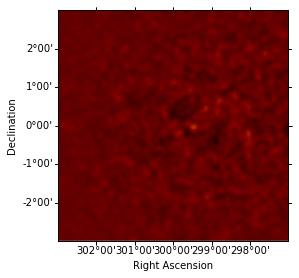

In [58]:
for i in range(1,6) :
    sh.create_model_component('gauss2d', 'g'+str(i))
gs = [g0, g1, g2, g3, g4, g5]
sh.set_full_model(bkg + psf(g0+g1+g2+g3+g4+g5) * expo)

for i in range(1, len(gs)) :
    gs[i].ampl = 0   # initialize components with fixed, zero amplitude
    sh.freeze(gs[i])

for i in range(1, len(gs)) :
    maxcoord = resid_smo6.lookup_max()
    maxpix = resid_smo6.wcs_skycoord_to_pixel(maxcoord[0])
    gs[i].xpos = maxpix[0]
    gs[i].ypos = maxpix[1]
    gs[i].fwhm = 10
    gs[i].fwhm = maxcoord[1]

    sh.thaw(gs[i].fwhm)
    sh.thaw(gs[i].ampl)
    sh.fit()

    sh.thaw(gs[i].xpos)
    sh.thaw(gs[i].ypos)
    sh.fit()
    sh.freeze(gs[i])

    sh.save_resid("resid.fits", clobber=True)
    resid = SkyImage.read("resid.fits")
    resid_smo6 = resid.smooth(radius = 6)
    resid_smo6.show(vmin = -0.5, vmax = 2)

The criterion for a significant source detection is typically that it should improve the test statistic by at least 25 or 30. The last excess fitted (g5) thus not a significant source:

In [59]:
ampl  = g5.ampl.val # save g5 fitted amplitude value
g5.ampl = 0
stati = sh.get_stat_info()[0].statval # value of statistic without g5 in model
g5.ampl = ampl
statf = sh.get_stat_info()[0].statval # value of statistic with g5
delstat = stati - statf
print('Del_stat(g5) = ', delstat)

Del_stat(g5) =  24.740823692802223
